## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [139]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal

import matplotlib.pyplot as plt


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def ExtractSpectrumPeaks(signal, fft_freq):
    """
    Apply FFT to signal, bandpass with [40 BPM, 240 BPM], and sort the peak indeces based on their height
    
    Args:
        signal - the data signal (ppg, accx, accy, accz, or acc)
        fft_freq - the frequency values of the spectrogram (fft_freq = np.fft.rfftfreq(len(signal), 1/fs))
        
    Outputs:
        signal_pks - (1d ndarray) the indeces of the peaks, sorted from the greatest height
        signal_fft - (1d ndarray) the fft of the signal
    """
    # FFT on the signal
    signal_fft = np.abs(np.fft.rfft(signal))
    
    # bandpass: erase fft values outside of [40 BPM, 240 BPM] 
    for j, f in enumerate(fft_freq):
        if f <= 40/60.0 or f >= 240/60.0:
            signal_fft[j] = 0
    
    # detect peaks in the spectrum, convert to list
    signal_pks = scipy.signal.find_peaks(signal_fft)[0].tolist()
    
    # sort the peaks by their heights (descending)
    signal_pks.sort(reverse=True, key=lambda x: signal_fft[x])
    
    return np.array(signal_pks), signal_fft
    

def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Main code. Estimate the pulse rate and the confidence score.
    
    Args:
        data_fl: Troika dataset (data)
        ref_fl Troika dataset (ref)
        
    Outputs:
        errors: (1d ndarray) absolute error of the algorithm
        confidence: (1d ndarray) self-defined confidence score
    """
    # sampling rate
    fs = 125.0
    
    # load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # actual bpm
    actual_bpm_whole = sp.io.loadmat(ref_fl)['BPM0'][:, 0]
    # convert to bps (beats per second)
    actual_bps_whole = actual_bpm_whole / 60.0
    
    # number of windows
    n_windows = len(actual_bps_whole)
        
    # outputs
    errors = []
    confidence = []
    
    # cache the previous predicted frequecy index
    prev_pred_idx = None
        
    # estimate pulse rate in every window
    for i in range(n_windows):
        # create a sliding window of width 8 sec and 6s overlap
        # start and end indeces
        start = int(i*2*fs)
        end = int(i*2*fs + 8*fs)
        
        # segment the signal
        ppg_w = ppg[start:end]
        accx_w = accx[start:end]
        accy_w = accy[start:end]
        accz_w = accz[start:end]
        
        # calculate total acc
        acc_w = np.sqrt(np.square(accx_w) + np.square(accy_w) + np.square(accz_w))
    
        ## fast fourier transform
        # with 8-s windows, the freq resolution is 0.125 Hz
        # with [40, 240] bandpass, there will be 26 non-vanising fft values
        fft_freq = np.fft.rfftfreq(len(ppg_w), 1/fs)
        
        ## Extract peak indeces from the spectrum (sorted)
        ppg_peaks, ppg_fft = ExtractSpectrumPeaks(ppg_w, fft_freq)
        accx_peaks, _ = ExtractSpectrumPeaks(accx_w, fft_freq)
        accy_peaks, _ = ExtractSpectrumPeaks(accy_w, fft_freq)
        accz_peaks, _ = ExtractSpectrumPeaks(accz_w, fft_freq)
        acc_peaks, _ = ExtractSpectrumPeaks(acc_w, fft_freq)
                
        ## Filter dubious peaks (remove dominant peaks in the x/y/z/total acceleration signal)
        ppg_peaks = ppg_peaks[ppg_peaks != accx_peaks[0]]
        ppg_peaks = ppg_peaks[ppg_peaks != accy_peaks[0]]
        ppg_peaks = ppg_peaks[ppg_peaks != accz_peaks[0]]
        ppg_peaks = ppg_peaks[ppg_peaks != acc_peaks[0]]
        
        ## Select the peak with the greatest height
        pred_idx = ppg_peaks[0]
        
        ## If observing an abrupt change (>1 Hz) in bps
        # --> move the prediction closer to the prediction from the previous window
        if i != 0:
            if abs(fft_freq[pred_idx] - fft_freq[prev_pred_idx]) >= 1:
                # find the index from ppg_peaks that is closest to the previous prediction
                closest_idx = min(ppg_peaks, key=lambda x: abs(x-prev_pred_idx))
                # chose the midpoint between them as an conservative prediction
                pred_idx = min(pred_idx, closest_idx) + abs(pred_idx-closest_idx)//2
        
        ## The predicted BPS (Hz)
        y_pred = fft_freq[pred_idx]
        
        # actual pulse rate (BPS)
        y_true = actual_bps_whole[i]
        
        # update prev_pred_idx
        prev_pred_idx = pred_idx
        
        #print("Pred: {:.2f}, Actual: {:.2f}".format(y_pred, y_true))
        
        # calculate absolute error (convert to BPM)
        errors.append(60.0*abs(y_pred-y_true))
        
        ## calculate confidence
        # we will integrate the area that is within 0.25 Hz from the predicted BPS
        conf_width = 0.25 # in Hz 
        # total area under the ppg spectrun
        area_under_whole_ppg_spectrum = np.sum(ppg_fft)
        # area near the predicted frequency
        area_near_prediction = sum(ppg_fft[np.abs(fft_freq-y_pred) <= conf_width])
        # calculate the ratio as the confidence score
        confidence.append(area_near_prediction/area_under_whole_ppg_spectrum)
        
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors = np.array(errors)
    confidence = np.array(confidence)
    
    return errors, confidence

## Test the `RunPulseRateAlgorithm` on a single file

In [140]:
errors, confidence = RunPulseRateAlgorithm(data_fls[1], ref_fls[1])

## Evaluate `RunPulseRateAlgorithm`

In [141]:
Evaluate()

13.606295685161244

## Exploratory data analysis

In [142]:
data_fls, ref_fls = LoadTroikaDataset()

In [143]:
data_fls

['./datasets/troika/training_data/DATA_01_TYPE01.mat',
 './datasets/troika/training_data/DATA_02_TYPE02.mat',
 './datasets/troika/training_data/DATA_03_TYPE02.mat',
 './datasets/troika/training_data/DATA_04_TYPE01.mat',
 './datasets/troika/training_data/DATA_04_TYPE02.mat',
 './datasets/troika/training_data/DATA_05_TYPE02.mat',
 './datasets/troika/training_data/DATA_06_TYPE02.mat',
 './datasets/troika/training_data/DATA_07_TYPE02.mat',
 './datasets/troika/training_data/DATA_08_TYPE02.mat',
 './datasets/troika/training_data/DATA_10_TYPE02.mat',
 './datasets/troika/training_data/DATA_11_TYPE02.mat',
 './datasets/troika/training_data/DATA_12_TYPE02.mat']

In [144]:
ref_fls

['./datasets/troika/training_data/REF_01_TYPE01.mat',
 './datasets/troika/training_data/REF_02_TYPE02.mat',
 './datasets/troika/training_data/REF_03_TYPE02.mat',
 './datasets/troika/training_data/REF_04_TYPE01.mat',
 './datasets/troika/training_data/REF_04_TYPE02.mat',
 './datasets/troika/training_data/REF_05_TYPE02.mat',
 './datasets/troika/training_data/REF_06_TYPE02.mat',
 './datasets/troika/training_data/REF_07_TYPE02.mat',
 './datasets/troika/training_data/REF_08_TYPE02.mat',
 './datasets/troika/training_data/REF_10_TYPE02.mat',
 './datasets/troika/training_data/REF_11_TYPE02.mat',
 './datasets/troika/training_data/REF_12_TYPE02.mat']

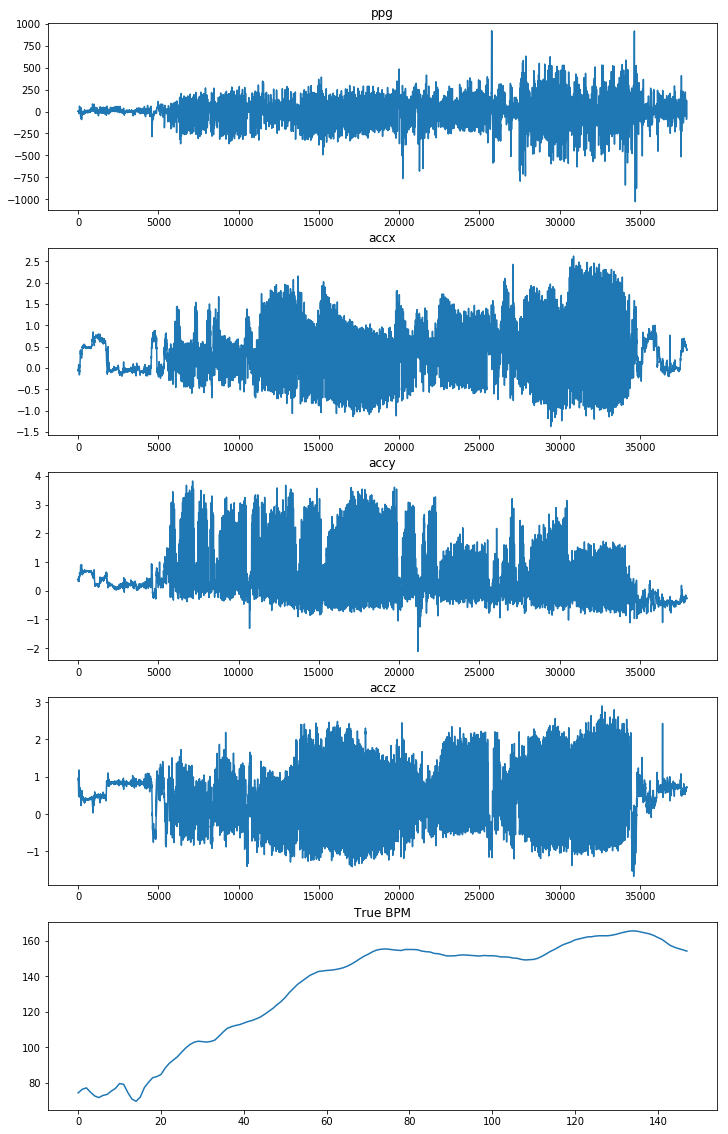

In [145]:
## Plot a data/ref example
idx = 0

data_sample = LoadTroikaDataFile(data_fls[idx])
ref_sample = sp.io.loadmat(ref_fls[idx])['BPM0']

ppg = data_sample[0]
accx = data_sample[1]
accy = data_sample[2]
accz = data_sample[3]
acc = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))
y_true = ref_sample

plt.figure(figsize=(12,20))
plt.subplot(5,1,1)
plt.plot(ppg) # ppg
plt.title("ppg")

plt.subplot(5,1,2)
plt.plot(accx) # accx
plt.title("accx")

plt.subplot(5,1,3)
plt.plot(accy) # accy
plt.title("accy")

plt.subplot(5,1,4)
plt.plot(accz) # accz
plt.title("accz")

plt.subplot(5,1,5)
plt.plot(y_true) # true y
plt.title("True BPM")

plt.show()


In [ ]:
## Plot spectrogram
plt.figure(figsize=(20, 10))

plt.subplot(1,5,1)
plt.specgram(ppg, Fs=125.0)
plt.title('ppg')

plt.subplot(1,5,2)
plt.specgram(acc, Fs=125.0)
plt.title('acc')

plt.subplot(1,5,3)
plt.specgram(accx, Fs=125.0)
plt.title('accx')

plt.subplot(1,5,4)
plt.specgram(accy, Fs=125.0)
plt.title('accy')

plt.subplot(1,5,5)
plt.specgram(accz, Fs=125.0)
plt.title('accz')

plt.show()



-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

#### Code Description

The **Code** section contains 6 functions, 4 were provided with the project and 2 were written by self:

- `LoadTroikaDataset` (provided) loads the Troika dataset and returns 2 lists **data_fls** and **ref_fls**.
    - data_fls contains the filenames of the physiological data
    - ref_fls contains the filenames to the actual pulse rate data.

- `LoadTroikaDataFile` (provided) loads a single data file.
    - It takes the filename as the argument.
    - The function returns a numpy array **data** of shape (4, n_samples)
    - data[0]: photoplethysmography (PPG) signal
    - data[1]: acceleration signal along the x-axis
    - data[2]: acceleration signal along the y-axis
    - data[3]: acceleration signal along the z-axis

- `AggregateErrorMetric` (provided) chooses the 90% best estimate (whose confidence score is above the 10th percentile) and calculates the mean absolute error (MAE) of these estimates.

- `Evaluate` (provided) evaluates the algorithm (details given below) on the whole training dataset. It combines the estimates and the confidence scores from every data files in the training dataset and calls the function `AggregateErrorMetric` to calculate the MAE of the 90% best estimate.

- `ExtractSpectrumPeaks` (self-written) processes the signal in the frequency domain to extract features by the following steps. The function returns 2 numpy arrays **signal_pks** and **signal_fft**
    - The signal is passed through a fast fourier transform (FFT) by using `numpy.fft.rfft()`
    - The frequency component below 40 BPM (2/3 Hz) or above 240 BPM (4 Hz) were removed (by simply replaced by zeros)
    - Peaks in the spectrum are detected by `scipy.signal.find_peaks()`
    - Peaks are sorted based on it's height in the spectrum (descendingly)
    - The indeces of the sorted peaks (signal_pks) and the spectrum data (signal_fft) are returned
    
- `RunPulseRateAlgorithm` (self-written) is the main algorithm that estimate the pulse rate from the PPG and acceleration data. Given data_fl and ref_fl from a single data file, the algorithm estimates the pulse rate and calculate the absolute errors from the actual values and their corresponding confidence scores. More details can be found in the **Algorithm Description** below.

#### Data Description

Each data file contains a **data_fls** and **ref_fls**

- data_fls (a list of filenames) contains the paths to the physiological data
- ref_fls (a list of filenames) contains the paths to the actual pulse rate data.

Physioloical data can be extracted by loading **data_fls[i]** by the function `LoadTroikaDataFile` into a numpy array of shape (4, length_of_signal):
- data[0]: photoplethysmography (PPG) signal
- data[1]: acceleration signal along the x-axis
- data[2]: acceleration signal along the y-axis
- data[3]: acceleration signal along the z-axis

The actual pulse rate can be extracted by loading **ref_fls[i]** by using `sp.io.loadmat(ref_fls[i])['BPM0'][:, 0]`. This gives a 1-dimensional numpy array of the actual pulse rate. The acutal pulse rate values were calculated by a sliding window (width = 8 sec, step size = 2 sec). In other words, the first value is the actual pulse rate from 0 sec to 8 sec, the second value is the actual pulse rate from 2 sec to 10 sec, and so on.

**short-comings**: The data were measured by a wristband. It's possible that the wristband could move while the user is wearing it and performs movements. Also the acutal pulse rates were calculated by an 8-second sliding window of step size 2 seconds. By changing these 2 parameters (window width and the step size), different acutual pulse rates can be obtained. It is therefore important to quantified the confidence level in the "acutal pulse rate" estimate. 

#### Algorithm Description

the algorithm works by the following:

- Individual ppg, accx, accy, accz signals are loaded by the function `LoadTroikaDataFile`
- Actual pulse rate data are loaded by `actual_bpm_whole = sp.io.loadmat(ref_fl)['BPM0'][:, 0]`
- The data signals (ppg, acc's) were segmented in the same way as the actual pulse rate data: using a sliding window with `width = 8` seconds and `step size = 2` seconds. Each window has its corresponding acutal pulse rate value in `actual_bpm_whole`
- Iterate through each segmented window, and in each window:
    - Calculate the total acceleration (acc) by taking the square root of the sum of the squares of the accx, accy, and accz
    - Use the helper function `ExtractSpectrumPeaks` to extract the peaks from the spectrums of the ppg, accx, accy, accz, and acc. The details of the helper function can be found above in the "Code description" section
    - I removed the peaks from the ppg spectrum if a peak at the same frequency is also observed as a dominant peak in any of the acceleration signal (x, y, z, and total acc). This is because I suspect that the ppg is picking up this frequency due to the movement of the wristband and not by the pulse rate.
    - After removing those accelearion-related peaks. I choose the highest peak in the remaining peaks as my pulse rate estimate.
    - **(heuristic method)** I observed that the algorithm could give a high error if it gives a prediction that is too far away from its prediction made from the previous window. Theoretically the pulse rate can not change so abruptly. To take this physiological aspect into account, I introduce a heuristic method to correct any abrupt change in the model prediction: for each prediction, if it's more than 1 Hz away from its previous prediction (which is how I define the change as abrupt), I will correct my prediction by using the midpoint between the current and its previous prediction as my prediction instead. This method works like a median filter on my model output. By doing this, I can reduce the chance that the algorithm produces a "jumpy" pulse rate. This method works.
    - **(confidence score)** The confidence is calculated by dividing **area_near_prediction** by **area_under_whole_ppg_spectrum**
        - area_near_prediction is the area under the spectrum that is within 0.25 Hz from the predicted pulse rate
        - area_under_whole_ppg_spectrum is the area under the whole ppg spectrum (from 2/3 Hz to 4 Hz)
        - the logic is that when a predicted pulse rate has a dominant peak in the spectrum (larger area ratio), it's more likely that this is closer the actual pulse rate
- Finally, the algorithm calculates the absolute error of the prediction from the acutal pulse rate, and returns 2 numpy arrays: a list of the absolute errors of each window, and a list of the confidence scores of each window.

Based on the algorithm I implememted. The model could fail if the actual pulse rate is the same as the movement of the wrist. If this is the scenario, the algorithm may not be able to find the actual pulse rate becuase it would remove the peak that is dominating in the acceleration signal.

#### Algorithm Performance

The algorithm achieves **MAE = 13.606** on the training dataset.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 